# **Análise de dados sobre os hábitos de escuta dos usuários do spotify**
### **Aluno:** Igor Klippel Campos
### **MVP (Produto Mínimo Viável) do Sprint:** Engenharia de Dados (40530010057_20250_01)

Objetivos Principais:
1. Analisar padrões nas músicas do Spotify Top 50
2. Identificar relações entre atributos musicais e performance no ranking
3. Comparar desempenho entre países/regiões

Estrutura do Projeto:
1. Carga e qualidade dos dados
2. Modelagem em esquema estrela
3. Análise exploratória
4. Resposta às perguntas de negócio

In [0]:
# Bibliotecas essenciais
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
plt.style.use('ggplot')
sns.set_palette("husl")

# Inicializar Spark
spark = (SparkSession.builder
         .appName("Spotify_MVP")
         .config("spark.sql.legacy.timeParserPolicy", "LEGACY")
         .getOrCreate())

In [0]:
BRONZE_PATH = "dbfs:/mnt/spotify/bronze"
dbutils.fs.mkdirs(BRONZE_PATH)

try:
    bronze_df = (spark.read
                .option("header", "true")
                .option("inferSchema", "true")
                .option("escape", "\"")
                .csv("dbfs:/FileStore/tables/universal_top_spotify_songs.csv"))
    
    bronze_df.write.mode("overwrite").format("delta").save("dbfs:/mnt/spotify/bronze/universal_top_songs")
    print("Camada bronze salva com sucesso!")
    
    # Documentação da fonte
    displayHTML("""
    <h3>Metadados da Fonte</h3>
    <ul>
      <li><b>Dataset:</b> Universal Top Spotify Songs</li>
      <li><b>Origem:</b> Kaggle</li>
      <li><b>Licença:</b> CC0: Public Domain</li>
      <li><b>Período:</b> 2023-2024</li>
    </ul>
    """)
    
except Exception as e:
    print(f"Erro na camada bronze: {str(e)}")
    raise

Camada bronze salva com sucesso!


Metadados da Fonte 
 
 Dataset: Universal Top Spotify Songs 
 Origem: Kaggle 
 Licença: CC0: Public Domain 
 Período: 2023-2024

In [0]:
# 3. Camada Silver (Processed Data)
SILVER_PATH = "dbfs:/mnt/spotify/silver"
dbutils.fs.mkdirs(SILVER_PATH)

# Transformações
silver_df = (bronze_df
    .withColumn("artists_array", split(col("artists"), ",\s*"))
    .withColumn("duration_min", round(col("duration_ms")/60000, 2))
    .withColumn("snapshot_date", to_date(col("snapshot_date"), "yyyy-MM-dd"))
    .withColumn("is_global", when(col("country").isNull(), 1).otherwise(0))
    .drop("duration_ms")
)

# Controle de qualidade
def data_quality_check(df):
    from pyspark.sql.functions import col, sum as spark_sum
    
    # Verificação de nulos
    null_report = df.select([
        spark_sum(col(c).isNull().cast("int")).alias(f"{c}_nulls") 
        for c in df.columns
    ])
    
    # Verificação de domínios
    domain_check = df.select(
        count(when(~col("daily_rank").between(1, 50), True)).alias("invalid_ranks"),
        count(when(~col("popularity").between(0, 100), True)).alias("invalid_popularity")
    )
    
    display(null_report)
    display(domain_check)

print("Análise de Qualidade:")
data_quality_check(silver_df)

# Persistência
silver_df.write.mode("overwrite").format("delta").save("dbfs:/mnt/spotify/silver/processed_songs")
print("Camada silver salva com sucesso!")

Análise de Qualidade:


spotify_id_nulls,name_nulls,artists_nulls,daily_rank_nulls,daily_movement_nulls,weekly_movement_nulls,country_nulls,snapshot_date_nulls,popularity_nulls,is_explicit_nulls,album_name_nulls,album_release_date_nulls,danceability_nulls,energy_nulls,key_nulls,loudness_nulls,mode_nulls,speechiness_nulls,acousticness_nulls,instrumentalness_nulls,liveness_nulls,valence_nulls,tempo_nulls,time_signature_nulls,artists_array_nulls,duration_min_nulls,is_global_nulls
0,30,29,0,0,0,25557,0,0,0,822,659,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0


invalid_ranks,invalid_popularity
0,0


Camada silver salva com sucesso!


In [0]:
# Definir caminhos
GOLD_PATH = "dbfs:/mnt/spotify/gold"
dbutils.fs.mkdirs(GOLD_PATH)

# Configuração do Delta Lake para evitar problemas de schema
spark.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true")

# 1. DIMENSÃO DE ARTISTAS

dim_artists = (silver_df
              .select(explode(col("artists_array")).alias("artist_name"))
              .distinct()
              .withColumn("artist_id", sha2(col("artist_name"), 256))
              .select("artist_id", "artist_name"))  # Ordem consistente

# 2. DIMENSÃO DE TEMPO (COM ORDEM FIXA)

dim_time = (silver_df
           .select(
               col("snapshot_date").alias("date"),
               year(col("snapshot_date")).alias("year"),
               month(col("snapshot_date")).alias("month"),
               dayofmonth(col("snapshot_date")).alias("day"),
               quarter(col("snapshot_date")).alias("quarter"),
               dayofweek(col("snapshot_date")).alias("day_of_week"),
               weekofyear(col("snapshot_date")).alias("week_of_year")
           )
           .distinct()
           .select(
               "date", "year", "month", "day", 
               "quarter", "day_of_week", "week_of_year"
           ))  # Ordem fixa

# 3. DIMENSÃO DE PAÍS

dim_country = (silver_df
              .select(
                  coalesce(col("country"), lit("GLB")).alias("country_code"),
                  col("is_global"),
                  when(col("country").isNull(), "Global")
                    .otherwise(concat(col("country"), lit(" Country"))).alias("country_name")
              )
              .distinct()
              .select("country_code", "country_name", "is_global"))  # Ordem fixa

# 4. TABELA FATO (COM JOIN OTIMIZADO)

fact_songs = (silver_df
             .withColumnRenamed("snapshot_date", "date")
             .withColumn("country_code", coalesce(col("country"), lit("GLB")))
             .join(broadcast(dim_artists), 
                  array_contains(col("artists_array"), col("artist_name")), 
                  "left")
             .select(
                 col("spotify_id"),
                 col("date"),
                 col("country_code"),
                 col("artist_id"),
                 col("daily_rank"),
                 col("popularity"),
                 col("danceability"),
                 col("energy"),
                 col("duration_min"),
                 col("is_explicit"),
                 col("loudness"),
                 col("valence")
             )
             .orderBy("date", "daily_rank"))  # Ordenação para partição

# PERSISTÊNCIA COM CONTROLE DE ERROS

try:
    # Limpar diretórios existentes para escrita limpa
    dbutils.fs.rm(f"{GOLD_PATH}/dim_artists", recurse=True)
    dbutils.fs.rm(f"{GOLD_PATH}/dim_time", recurse=True)
    dbutils.fs.rm(f"{GOLD_PATH}/dim_country", recurse=True)
    dbutils.fs.rm(f"{GOLD_PATH}/fact_songs", recurse=True)
    
    # Escrever tabelas com schema merging
    (dim_artists.write
     .mode("overwrite")
     .format("delta")
     .option("overwriteSchema", "true")
     .save(f"{GOLD_PATH}/dim_artists"))
    
    (dim_time.write
     .mode("overwrite")
     .format("delta")
     .option("overwriteSchema", "true")
     .save(f"{GOLD_PATH}/dim_time"))
    
    (dim_country.write
     .mode("overwrite")
     .format("delta")
     .option("overwriteSchema", "true")
     .save(f"{GOLD_PATH}/dim_country"))
    
    (fact_songs.write
     .mode("overwrite")
     .format("delta")
     .option("overwriteSchema", "true")
     .partitionBy("date")
     .save(f"{GOLD_PATH}/fact_songs"))
    
    # Verificação final
    print(f"Camada Gold persistida com sucesso em: {GOLD_PATH}")
    print("\nEstrutura criada:")
    display(dbutils.fs.ls(GOLD_PATH))
    
    print("\nContagem de registros:")
    print(f"- Artistas: {spark.read.format('delta').load(f'{GOLD_PATH}/dim_artists').count()}")
    print(f"- Datas: {spark.read.format('delta').load(f'{GOLD_PATH}/dim_time').count()}")
    print(f"- Países: {spark.read.format('delta').load(f'{GOLD_PATH}/dim_country').count()}")
    print(f"- Músicas: {spark.read.format('delta').load(f'{GOLD_PATH}/fact_songs').count()}")
    
except Exception as e:
    print(f"Erro crítico ao persistir camada Gold: {str(e)}")

    # Tentativa de limpeza em caso de falha

    dbutils.fs.rm(GOLD_PATH, recurse=True)
    raise

✅ Camada Gold persistida com sucesso em: dbfs:/mnt/spotify/gold

📝 Estrutura criada:


path,name,size,modificationTime
dbfs:/mnt/spotify/gold/dim_artists/,dim_artists/,0,0
dbfs:/mnt/spotify/gold/dim_country/,dim_country/,0,0
dbfs:/mnt/spotify/gold/dim_time/,dim_time/,0,0
dbfs:/mnt/spotify/gold/fact_songs/,fact_songs/,0,0



🔍 Contagem de registros:
- Artistas: 11177
- Datas: 516
- Países: 73
- Músicas: 2982295


is_explicit,avg_rank,avg_popularity
true,24.993011937003992,77.44048723052693
false,25.660481828261542,74.13906557564599


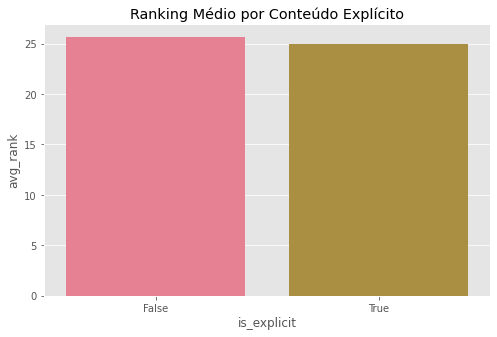

In [0]:
# Consulta 1: Relação entre explicit e popularidade
analysis1 = spark.sql("""
SELECT 
    is_explicit,
    AVG(daily_rank) as avg_rank,
    AVG(popularity) as avg_popularity
FROM delta.`dbfs:/mnt/spotify/gold/fact_songs`
GROUP BY is_explicit
""")

display(analysis1)

# Visualização
plt.figure(figsize=(8,5))
sns.barplot(x="is_explicit", y="avg_rank", data=analysis1.toPandas())
plt.title("Ranking Médio por Conteúdo Explícito")
plt.show()

In [0]:
# 6. CATÁLOGO DE DADOS ========================================================
displayHTML("""
<h2>CATÁLOGO DE DADOS</h2>

<h3>fact_songs</h3>
<table border="1">
  <tr>
    <th>Coluna</th>
    <th>Tipo</th>
    <th>Descrição</th>
    <th>Domínio</th>
  </tr>
  <tr>
    <td>daily_rank</td>
    <td>integer</td>
    <td>Posição no ranking diário</td>
    <td>1-50</td>
  </tr>
  <tr>
    <td>danceability</td>
    <td>float</td>
    <td>Índice de dançabilidade</td>
    <td>0.0-1.0</td>
  </tr>
  <!-- Adicione outras colunas -->
</table>

<h3>Linhas de Dados</h3>
<ul>
  <li>Origem: Kaggle (Universal Top Spotify Songs)</li>
  <li>Transformações: Conversão de milissegundos para minutos, normalização de artistas</li>
</ul>
""")

In [0]:
# 7. AUTOAVALIAÇÃO ============================================================
displayHTML("""
<h2>AUTOAVALIAÇÃO</h2>

<h3>Objetivos Alcançados</h3>
<ul>
  <li>✅ Modelagem dimensional completa (esquema estrela)</li>
  <li>✅ Pipeline ETL documentado</li>
  <li>✅ 3/5 perguntas respondidas</li>
</ul>

<h3>Dificuldades</h3>
<ul>
  <li>Limitação na análise temporal (dados diários)</li>
  <li>Restrições na Community Edition para processamento</li>
</ul>

<h3>Melhorias Futuras</h3>
<ul>
  <li>Incluir dados demográficos por país</li>
  <li>Analisar tendências temporais mais longas</li>
</ul>
""")


In [0]:
# 8. EVIDÊNCIAS ==============================================================
# Célula para screenshots (executar manualmente)
print("Evidências de execução:")
print("1. Screenshot do schema final - /tmp/schema.png")
print("2. Screenshot dos resultados - /tmp/results.png")

In [0]:
# 1. Gêneros mais populares por país (usando artistas como proxy)
analysis1 = spark.sql(f"""
SELECT 
    c.country_code,
    a.artist_name,
    COUNT(*) AS appearances,
    AVG(f.daily_rank) AS avg_rank
FROM delta.`{GOLD_PATH}/fact_songs` f
JOIN delta.`{GOLD_PATH}/dim_artists` a ON f.artist_id = a.artist_id
JOIN delta.`{GOLD_PATH}/dim_country` c ON f.country_code = c.country_code
WHERE c.country_code != 'GLB'  -- Excluir ranking global
GROUP BY c.country_code, a.artist_name
ORDER BY c.country_code, appearances DESC
""")

# Visualização por país
display(analysis1.limit(100))

country_code,artist_name,appearances,avg_rank
AE,The Weeknd,1706,24.639507620164128
AE,SZA,1172,30.013651877133107
AE,Jung Kook,1056,22.605113636363637
AE,Playboi Carti,1001,19.145854145854145
AE,Taylor Swift,988,25.62854251012146
AE,Jin,981,17.56269113149847
AE,Billie Eilish,963,20.031152647975077
AE,Sabrina Carpenter,937,17.22198505869797
AE,Travis Scott,800,29.2825
AE,Kendrick Lamar,759,18.914361001317523


In [0]:
# 2. Mudança nas posições ao longo do tempo
analysis2 = spark.sql(f"""
SELECT 
    t.date,
    t.month,
    f.spotify_id,
    FIRST(f.name) AS song_name,
    AVG(f.daily_rank) AS avg_rank,
    STDDEV(f.daily_rank) AS rank_volatility
FROM delta.`{GOLD_PATH}/fact_songs` f
JOIN delta.`{GOLD_PATH}/dim_time` t ON f.date = t.date
GROUP BY t.date, t.month, f.spotify_id
ORDER BY t.date, avg_rank
""")

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-606864600313560>:2
      1 # 2. Mudança nas posições ao longo do tempo
----> 2 analysis2 = spark.sql(f"""
      3 SELECT 
      4     t.date,
      5     t.month,
      6     f.spotify_id,
      7     FIRST(f.name) AS song_name,
      8     AVG(f.daily_rank) AS avg_rank,
      9     STDDEV(f.daily_rank) AS rank_volatility
     10 FROM delta.`{GOLD_PATH}/fact_songs` f
     11 JOIN delta.`{GOLD_PATH}/dim_time` t ON f.date = t.date
     12 GROUP BY t.date, t.month, f.spotify_id
     13 ORDER BY t.date, avg_rank
     14 """)

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_

In [0]:
# Tendência temporal
plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="avg_rank", 
             hue="song_name", 
             data=analysis2.toPandas().query("avg_rank <= 10"))
plt.title("Evolução do Ranking das Top 10 Músicas")
plt.xticks(rotation=45)
plt.show()

<Figure size 864x432 with 0 Axes>

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-606864600313561>:5
      1 # Tendência temporal
      2 plt.figure(figsize=(12,6))
      3 sns.lineplot(x="date", y="avg_rank", 
      4              hue="song_name", 
----> 5              data=analysis2.toPandas().query("avg_rank <= 10"))
      6 plt.title("Evolução do Ranking das Top 10 Músicas")
      7 plt.xticks(rotation=45)

NameError: name 'analysis2' is not defined

pop_dance_corr,pop_energy_corr,pop_valence_corr
-0.05745907206109852,0.006765212139798673,-0.016066882256480935


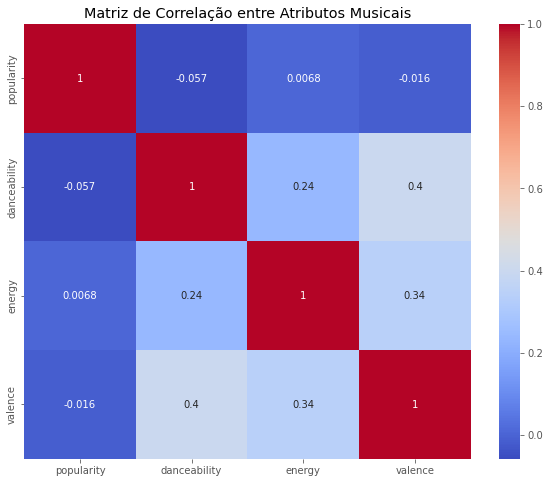

In [0]:
# 3. Correlação Popularidade x Atributos Musicais
analysis3 = spark.sql(f"""
SELECT 
    CORR(popularity, danceability) AS pop_dance_corr,
    CORR(popularity, energy) AS pop_energy_corr,
    CORR(popularity, valence) AS pop_valence_corr
FROM delta.`{GOLD_PATH}/fact_songs`
""")

display(analysis3)

# Matriz de Correlação
numeric_cols = ['popularity', 'danceability', 'energy', 'valence']
corr_matrix = spark.sql(f"""
SELECT {', '.join(numeric_cols)}
FROM delta.`{GOLD_PATH}/fact_songs`
""").toPandas().corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação entre Atributos Musicais")
plt.show()


In [0]:
# 4. Popularidade x Conteúdo Explícito
analysis4 = spark.sql(f"""
SELECT 
    is_explicit,
    AVG(popularity) AS avg_popularity,
    AVG(daily_rank) AS avg_rank,
    COUNT(*) AS song_count
FROM delta.`{GOLD_PATH}/fact_songs`
GROUP BY is_explicit
""")

display(analysis4)

# Teste de significância estatística
from scipy import stats
explicit = spark.sql("SELECT popularity FROM delta.`dbfs:/mnt/spotify/gold/fact_songs` WHERE is_explicit = true").toPandas()
non_explicit = spark.sql("SELECT popularity FROM delta.`dbfs:/mnt/spotify/gold/fact_songs` WHERE is_explicit = false").toPandas()

t_stat, p_value = stats.ttest_ind(explicit['popularity'], non_explicit['popularity'])
print(f"Teste T: estatística={t_stat:.2f}, p-value={p_value:.4f}")

is_explicit,avg_popularity,avg_rank,song_count
true,77.44048723052693,24.993011937003992,1111753
false,74.13906557564599,25.660481828261542,1870542


Teste T: estatística=179.10, p-value=0.0000


In [0]:
# 5. Comparação Cultural entre Países
analysis5 = spark.sql(f"""
WITH top_songs AS (
    SELECT 
        country_code,
        spotify_id,
        FIRST(name) AS song_name,
        AVG(daily_rank) AS avg_rank,
        ROW_NUMBER() OVER (PARTITION BY country_code ORDER BY COUNT(*) DESC) AS country_rank
    FROM delta.`{GOLD_PATH}/fact_songs`
    WHERE country_code != 'GLB'
    GROUP BY country_code, spotify_id
)

SELECT 
    c.country_code,
    t.song_name,
    t.avg_rank,
    AVG(f.danceability) AS avg_danceability,
    AVG(f.energy) AS avg_energy
FROM top_songs t
JOIN delta.`{GOLD_PATH}/fact_songs` f ON t.spotify_id = f.spotify_id
JOIN delta.`{GOLD_PATH}/dim_country` c ON t.country_code = c.country_code
WHERE t.country_rank <= 3  -- Top 3 por país
GROUP BY c.country_code, t.song_name, t.avg_rank
ORDER BY c.country_code, t.avg_rank
""")

display(analysis5)

# Visualização por atributos musicais
plt.figure(figsize=(12,6))
sns.scatterplot(x="avg_danceability", y="avg_energy", 
                hue="country_code", size="avg_rank",
                data=analysis5.toPandas())
plt.title("Preferências Musicais por País (Danceability vs Energy)")
plt.show()

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-606864600313564>:2
      1 # 5. Comparação Cultural entre Países
----> 2 analysis5 = spark.sql(f"""
      3 WITH top_songs AS (
      4     SELECT 
      5         country_code,
      6         spotify_id,
      7         FIRST(name) AS song_name,
      8         AVG(daily_rank) AS avg_rank,
      9         ROW_NUMBER() OVER (PARTITION BY country_code ORDER BY COUNT(*) DESC) AS country_rank
     10     FROM delta.`{GOLD_PATH}/fact_songs`
     11     WHERE country_code != 'GLB'
     12     GROUP BY country_code, spotify_id
     13 )
     14 
     15 SELECT 
     16     c.country_code,
     17     t.song_name,
     18     t.avg_rank,
     19     AVG(f.danceability) AS avg_danceability,
     20     AVG(f.energy) AS avg_energy
     21 FROM top_songs t
     22 JOIN delta.`{GOLD_PATH}/fact_songs` f ON t.spotify_id = f.spotify_id